In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # blacklist tf warning and info

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py

/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/songzitao/anaconda3/envs/py36/lib

In [3]:
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook

In [4]:
from environment.portfolio import PortfolioEnv

In [5]:

eps=1e-8

In [6]:
abbreviations = ['AAPL.O',
                 'ADBE.O',
                 'AMZN.O',
                 'DIS.N',
                 'GOOGL.O',
                 'JNJ.N',
                 'JPM.N',
                 'MSFT.O',
                 'NFLX.O',
                 'PG.N']

In [7]:
import json
with open('configs/{}_default.json'.format('sac')) as f:
    config = json.load(f)

In [8]:
feature_number = config['input']['feature_number']
window_size = config['input']['window_size']
asset_number = config['input']['asset_number']

actor_learning_rate = config['training']['actor_learning_rate']
critic_learning_rate = config['training']['critic_learning_rate']
batch_size = config['training']['batch_size']
tau = config['training']['tau']        # frequency to update target net parameter
episodes = config['training']['episode']
policy_delay = 2
device = 'cpu'
actor_layers = config['actor_layers']
critic_layers = config['critic_layers']

In [22]:
with h5py.File('./Data/history_stock_price.h5','r') as f:
    history_stock_price = f['stock_price'][...]
    timestamp = [s.decode('utf-8') for s in f['timestamp']]
    abbreviations = [s.decode('utf-8') for s in f['abbreviations']]
    features = [s.decode('utf-8') for s in f['features']]

In [24]:
train_step = timestamp.index('2018-07-02')
valid_step = timestamp.index('2020-07-01')

In [25]:
history_stock_price_training = history_stock_price[:,:train_step,:]
history_stock_price_validating = history_stock_price[:,train_step:valid_step,:]
history_stock_price_testing = history_stock_price[:,valid_step:,:]
timestamp_training = timestamp[:train_step]
timestamp_validating = timestamp[train_step:valid_step]
timestamp_testing = timestamp[valid_step:]

In [26]:
env_training = PortfolioEnv(history=history_stock_price_training,
                                abbreviation=abbreviations,
                                timestamp=timestamp_training,
                                steps=3000)

# DDPG

In [13]:
models = []
model_names = []
this_models = ['sac']
episodes_list = [10,15]
window_length_lst = [20]
use_batch_norm = False
use_obs_normalizer_list = [True]
dtype = tf.float32


In [14]:
from model.ddpg.stockactor import DDPGActor
from model.ddpg.stockcritic import DDPGCritic
from model.ddpg.ddpg import DDPG
from model.sac.stockactor import SACActor
from model.td3.td3 import TD3
from model.sac.sac import SAC
from model.core.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

In [15]:
from train import get_path, get_variable_scope, test_model, test_model_multiple, obs_normalizer, normalize_obs_logdiff

# Load pretrained weights

In [16]:
models = []
for window_size in window_length_lst:
    for use_obs_normalizer in use_obs_normalizer_list:
        for episodes in episodes_list:
            for this_model in this_models:
                name = '%s_WIN%d_EPS%d_NOR%s'%(this_model,window_size,episodes,str(use_obs_normalizer))
                model_names.append(name)
                model_save_path = get_path('weights',model = this_model,
                                                     episode=episodes,
                                                     window_size=window_size,
                                                     use_batch_norm=use_batch_norm, 
                                                     use_obs_normalizer=use_obs_normalizer)

                variable_scope = get_variable_scope(window_size=window_size,
                                                    use_batch_norm=use_batch_norm,
                                                    use_obs_normalizer=use_obs_normalizer)

                actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(asset_number+1))
                print(model_save_path)
                tf.reset_default_graph()
                if use_obs_normalizer:
                    obs_normalizer = normalize_obs_logdiff
                    window_size_ = window_size - 1
                else:
                    window_size_ = window_size
                with tf.variable_scope(variable_scope):

                    sess = tf.Session()

                    if this_model =='sac':
                        dtype = tf.float64
                        tf.keras.backend.set_floatx('float64')
                        num_mixtrue = 5
                        stockactor = SACActor(sess, feature_number = feature_number,
                                                      config = config,
                                                      action_dim = asset_number + 1,
                                                      window_size = window_size_,
                                                      num_mixtrue = num_mixtrue,
                                                      learning_rate = actor_learning_rate,
                                                      action_bound=1,
                                                      layers = actor_layers,
                                                      tau=tau, batch_size=batch_size,dtype=dtype)
                    else:

                        stockactor = DDPGActor(sess, feature_number = feature_number,
                                                      config = config,
                                                      action_dim = asset_number + 1,
                                                      window_size = window_size_,
                                                      learning_rate = actor_learning_rate,
                                                      action_bound=1,
                                                      layers = actor_layers,
                                                      tau=tau, batch_size=batch_size)

                    stockcritic = DDPGCritic(sess, feature_number = feature_number,
                                                    config = config,
                                                    action_dim = asset_number+1,
                                                    window_size = window_size_,
                                                    learning_rate = critic_learning_rate,
                                                    num_actor_vars = stockactor.get_num_trainable_vars(),
                                                    layers = critic_layers,
                                                    tau=tau, batch_size=batch_size,dtype=dtype)


                    if this_model == 'ddpg':
                         model = DDPG(None,sess, actor = stockactor,
                                                         critic = stockcritic,
                                                         obs_normalizer = obs_normalizer,
                                                         actor_noise = actor_noise,
                                                         model_save_path = model_save_path,
                                                         summary_path = summary_path,
                                                         config = config)

                    elif this_model == 'td3' or this_model == 'sac':

                        stockcritic2 = DDPGCritic(sess, feature_number = feature_number,
                                                         config = config,
                                                         action_dim = asset_number+1,
                                                         window_size = window_size_,
                                                         learning_rate = critic_learning_rate,
                                                         num_actor_vars = stockactor.get_num_trainable_vars() + stockcritic.get_num_trainable_vars(),
                                                         layers = critic_layers,
                                                         tau=tau, batch_size=batch_size,dtype=dtype)
                        if this_model == 'td3':
                            model = TD3(None, sess,  actor = stockactor,
                                                             critic1 = stockcritic,
                                                             critic2 = stockcritic2,
                                                             obs_normalizer = obs_normalizer,
                                                             actor_noise = actor_noise,
                                                             policy_delay = policy_delay,
                                                             model_save_path = model_save_path,

                                                             config = config)
                        else:
                            model = SAC(None, sess,  actor = stockactor,
                                                             critic1 = stockcritic,
                                                             critic2 = stockcritic2,
                                                             obs_normalizer = obs_normalizer,
                                                             actor_noise = actor_noise,
                                                             policy_delay = policy_delay,
                                                             model_save_path = model_save_path,
                                                             config = config)
                    else:
                        raise("Model not Implemented Error")

                    model.initialize(load_weights=True, verbose=False)  # change to True to load weights
                    models.append(model)

weights/sac/window_20_no_batch_norm_normalized_eps_10_checkpoint.ckpt

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

INFO:tensorflow:Summary name step target1 loss is illegal; using step_target1_loss instead.
INFO:tensorflow:Summary name step target2 loss is illegal; using step_target2_loss instead.
INFO:tensorflow:Summary name step Q max is illegal; using step_Q_max instead.
INFO:tensorflow:Summary name step alpha loss is illegal; using step_alpha_loss instead.

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://g

# Testing DDPG Models on Validation set

In [35]:
validation_start_date = '2019-01-03'
history = history_stock_price_validating
timestamp = timestamp_validating
steps = 365

In [36]:
len(models)

2

In [59]:
from environment.portfolio import MultiActionPortfolioEnv

MuliActEnv_validating = MultiActionPortfolioEnv(history=history,
                                                abbreviation=abbreviations,
                                                timestamp=timestamp,
                                                model_names=model_names,
                                                window_length=max(window_length_lst),
                                                steps=steps,
                                                sample_start_date=validation_start_date)

In [60]:
envs = test_model_multiple(env=MuliActEnv_validating,models=models, policy_delay=policy_delay)

Start date: 2019-01-03, End date: 2020-06-01


<Figure size 432x288 with 0 Axes>

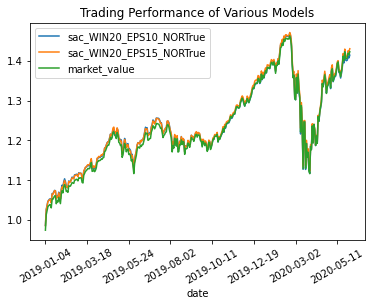

In [61]:
envs.render()

In [ ]:
weights = []
for i in range(steps+1):
    weights.append(envs.sim[0].infos[i]['weights'])
weights_matrix = np.concatenate([weights],axis=1)

In [ ]:
def barlist(i):
    return envs.sim[0].infos[i]['weights']

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook

In [ ]:
new_abbreviations = ['Cash'] + abbreviations

In [ ]:
def plot_ith_asset(ax,i):
    start_date_index = timestamp.index(validation_start_date)
    timestamp_plot = timestamp[start_date_index:start_date_index+steps]
    ax.set_title('%s'%(new_abbreviations[i]))
    color = "tab:red"
    ax.plot(np.arange(0,steps),weights_matrix[1:,i],color=color)
    ax.set_ylabel('Porfolio weights',color=color)
    ax.tick_params(axis='y',labelcolor=color)
    
    if i != 0:
        close_price = history[i-1,...][start_date_index:start_date_index+steps,3]
        ax2 = ax.twinx()
        color = "tab:blue"
        ax2.set_ylabel('%s Close Price' %(new_abbreviations[i]),color=color)
        ax2.plot(np.arange(0,steps),close_price,color=color)
        ax2.tick_params(axis='y',labelcolor=color)

    ax.set_xticks(np.arange(0,steps)[::15])
    ax.set_xticklabels(timestamp_plot[::15], rotation='45')
    
    return ax

In [ ]:
fig, axes = plt.subplots(nrows=3,ncols=4,sharex=True,sharey=True,figsize=(15,6))
for i in range(0,asset_number+1):
    row = i // 4
    col = i % 4
    ax = plot_ith_asset(axes[row,col],i)
    plt.tight_layout()
fig.delaxes(axes[2,3])
#fig.savefig('./figs/td3.pdf')

# Interactive display

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
n = 100 # frame numbers
x = ['Cash'] + abbreviations
barcollection = ax.bar(x, barlist(1))


def animate(i):
    y = barlist(i+1)
    for i, b in enumerate(barcollection):
        
        b.set_height(y[i])
        
anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n,
                             interval=100)
#anim.save('mymovie.mp4',writer=animation.FFMpegWriter(fps=5))
plt.show()

In [ ]:
start_date = envs.src.start_date
start_date

# Random Stratety on Validation set

In [40]:
env_validating = PortfolioEnv(history=history,
                                abbreviation=abbreviations,
                                timestamp=timestamp,
                                steps=steps,
                                sample_start_date=validation_start_date)

In [41]:
pre_obs, ground_truth_obs = env_validating.reset()
done = False
while not done:
    action = np.random.rand(11)
    observation, onestep_r, done, info = env_validating.step(action)

Start date: 2019-01-03, End date: 2020-06-01


<IPython.core.display.Javascript object>


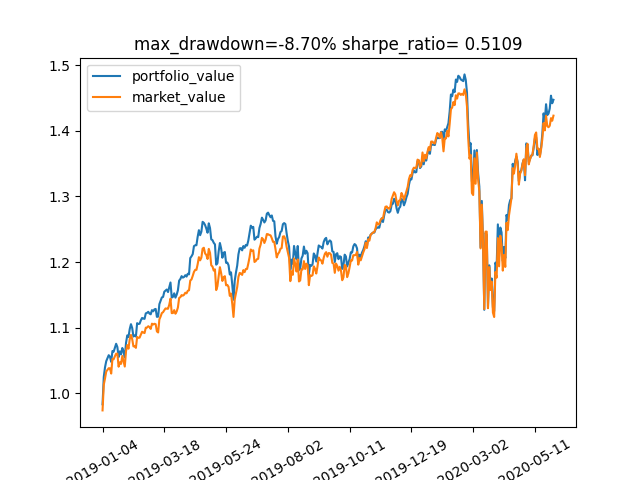

In [42]:
env_validating.render()

# Visualize results

In [43]:
from environment.portfolio import sharpe, max_drawdown

In [44]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline

In [45]:
envs_df = pd.DataFrame(envs.infos)
#envs_df['date'] =  pd.to_datetime(envs_df['date'], format='%Y-%m-%d')
envs_ran_df = pd.DataFrame(env_validating.infos)
#envs_ran_df['date'] =  pd.to_datetime(envs_ran_df['date'], format='%Y-%m-%d')

In [46]:
sharpes_dict = {model_name : sharpe(envs_df[model_name + '_rate_of_return']) for model_name in model_names}
mdd_dict = {model_name : max_drawdown(envs_df[model_name + '_rate_of_return']+1) for model_name in model_names}

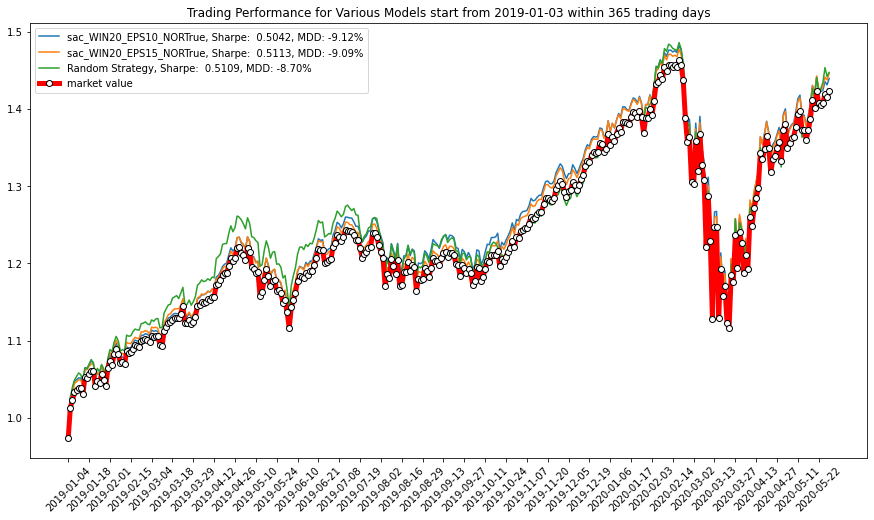

In [47]:
fig, ax = plt.subplots(figsize = (15,8))
ax.set_title('Trading Performance for Various Models start from {} within {} trading days'.format(validation_start_date, steps))

for i in range(0, len(model_names)):
    ax.plot(np.arange(0,len(envs_df)),envs_df[model_names[i]].to_numpy(),
            label = '{}, Sharpe: {: 2.4f}, MDD: {: 2.2%}'.format(model_names[i],
                                                            sharpes_dict[model_names[i]],
                                                            mdd_dict[model_names[i]]))
ax.plot(np.arange(0,len(envs_df)),envs_ran_df['portfolio_value'].to_numpy(),
         label = 'Random Strategy, Sharpe: {: 2.4f}, MDD: {: 2.2%}'.format(sharpe(envs_ran_df['rate_of_return']),
                                                               max_drawdown(envs_ran_df['rate_of_return']+1)))
ax.plot(np.arange(0,len(envs_df)),envs_df['market_value'].to_numpy(), 
        color='r',linewidth=5,marker='o',
        markerfacecolor='w',markeredgecolor='k',label = 'market value')
ax.set_xticks(np.arange(0,len(envs_df))[::10])
ax.set_xticklabels(envs_df['date'].to_numpy()[::10], rotation='45')
ax.legend(loc = 'best')
#fig.savefig('./figs/fig_%s_%s_%s.pdf'%(validation_start_date, steps, str(datetime.now())))